
# Data Mining – Baseline Logistic Regression (Bank Marketing)

**Mục tiêu:** dựng pipeline cơ bản với `scikit-learn`, huấn luyện **Logistic Regression** làm baseline.

**Metric chính:** ROC-AUC  
**Metric phụ:** PR-AUC, Recall, Precision, F1, Accuracy

**Lý do bỏ `duration`:** đây là thông tin chỉ có *sau* cuộc gọi (rò rỉ dữ liệu nếu dùng khi dự đoán trước cuộc gọi), nên **không được dùng để train/infer**.

**Quy trình:**
1) Import & đường dẫn  
2) Load dữ liệu  
3) EDA ngắn gọn  
4) Tiền xử lý & Pipeline  
5) Split 60/20/20 (Stratified)  
6) Train Logistic Regression (class_weight='balanced')  
7) Đánh giá: ROC/PR, classification_report, confusion_matrix  
8) Ghi nhận baseline (lưu reports/, models/)  
9) Việc tiếp theo


In [1]:

# %pip install -r ../requirements.txt  # <- chạy nếu cần cài nhanh trong notebook

import os
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# dùng module nội bộ trong src (ưu tiên import để đồng bộ code)
import sys
ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

DATA_PATH   = ROOT / "data" / "bank-full.csv"   # đổi tên nếu khác
REPORTS_DIR = ROOT / "reports"
MODELS_DIR  = ROOT / "models"

REPORTS_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

%matplotlib inline
sns.set_theme()


In [2]:

# Nếu bạn đã có src/data_loader.py thì import; nếu chưa, fallback đọc trực tiếp CSV
try:
    from src.data_loader import load_bank_data
    df = load_bank_data(DATA_PATH)
except Exception as e:
    print("Không import được src.data_loader, fallback đọc CSV trực tiếp:", e)
    # dataset bank marketing thường có sep=';'
    df = pd.read_csv(DATA_PATH, sep=';')
    df.columns = [c.strip().lower().replace('.', '_') for c in df.columns]

print(df.shape)
df.info()
display(df.head())

print("\nTỉ lệ lớp (y):")
print(df['y'].value_counts(dropna=False))


(45211, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no



Tỉ lệ lớp (y):
y
no     39922
yes     5289
Name: count, dtype: int64


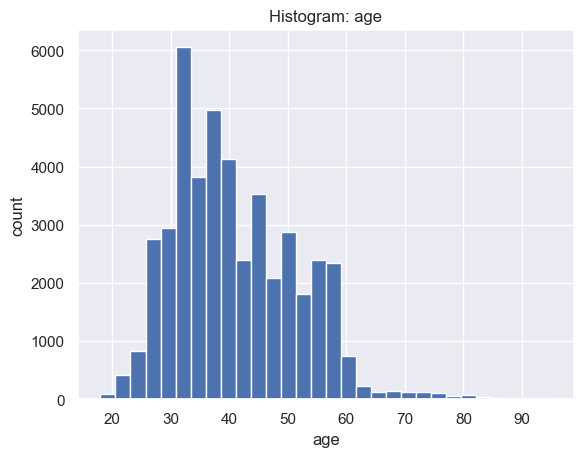

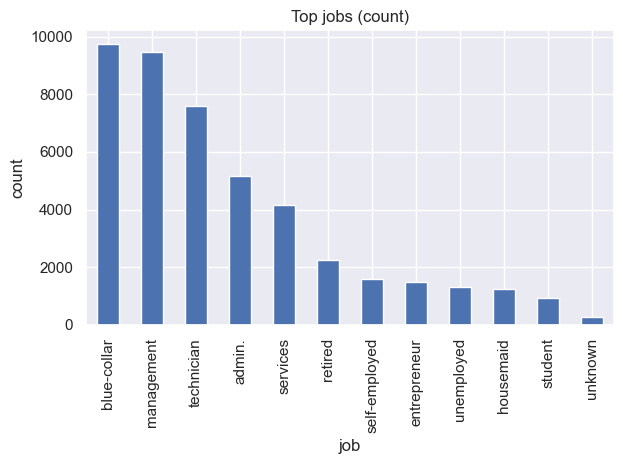

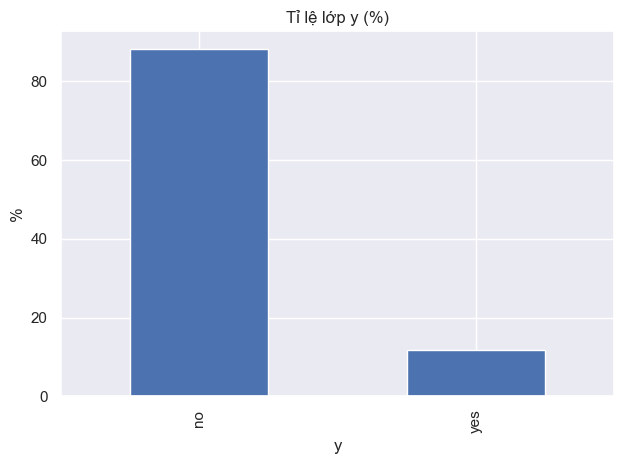

In [3]:

fig, ax = plt.subplots()
df['age'].hist(bins=30, ax=ax)
ax.set_title('Histogram: age')
ax.set_xlabel('age')
ax.set_ylabel('count')
plt.show()

plt.figure()
df['job'].value_counts().head(15).plot(kind='bar')
plt.title('Top jobs (count)')
plt.xlabel('job')
plt.ylabel('count')
plt.tight_layout()
plt.show()

plt.figure()
(df['y'].value_counts(normalize=True) * 100).plot(kind='bar')
plt.title('Tỉ lệ lớp y (%)')
plt.ylabel('%')
plt.tight_layout()
plt.show()


In [4]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

TARGET_COL = "y"
DROP_COLS = ["duration"]

# Chuẩn hoá nhãn: 'yes' -> 1, 'no' -> 0
if df[TARGET_COL].dtype == 'object':
    df[TARGET_COL] = (df[TARGET_COL].str.lower() == 'yes').astype(int)

# Bỏ cột duration nếu tồn tại
df_proc = df.copy()
for c in DROP_COLS:
    if c in df_proc.columns:
        df_proc = df_proc.drop(columns=c)

# phân loại feature types
features = [c for c in df_proc.columns if c != TARGET_COL]
cat_cols = [c for c in features if df_proc[c].dtype == 'object']
num_cols = [c for c in features if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)


In [5]:

X = df_proc.drop(columns=[TARGET_COL])
y = df_proc[TARGET_COL].values

RANDOM_STATE = 42

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=RANDOM_STATE
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Valid:", X_valid.shape, "Test:", X_test.shape)


Train: (27126, 15) Valid: (9042, 15) Test: (9043, 15)


In [6]:

lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    solver="lbfgs"
)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", lr)
])

pipe.fit(X_train, y_train)
print("Đã train xong baseline LR.")


Đã train xong baseline LR.



[VALID] ROC-AUC: 0.7644 | PR-AUC: 0.4028
[VALID] Classification report:
              precision    recall  f1-score   support

           0      0.938     0.770     0.846      7984
           1      0.262     0.617     0.368      1058

    accuracy                          0.752      9042
   macro avg      0.600     0.694     0.607      9042
weighted avg      0.859     0.752     0.790      9042

[VALID] Confusion matrix:
[[6148 1836]
 [ 405  653]]


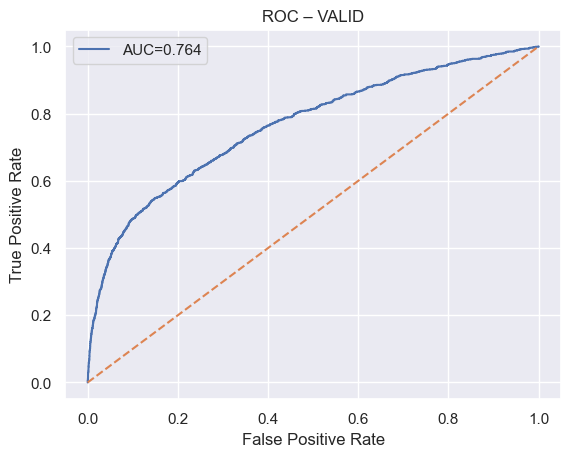

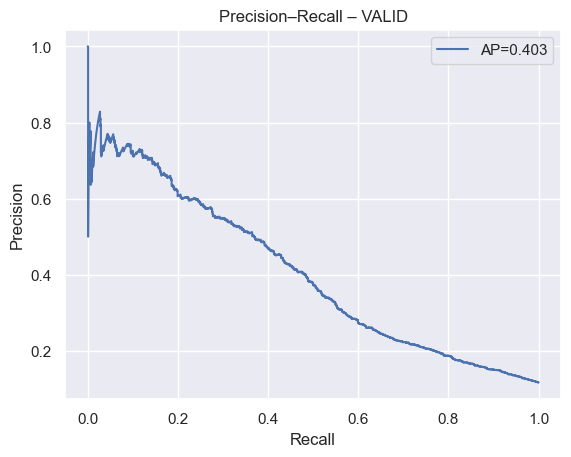


[TEST] ROC-AUC: 0.7767 | PR-AUC: 0.4372
[TEST] Classification report:
              precision    recall  f1-score   support

           0      0.943     0.776     0.851      7985
           1      0.276     0.644     0.386      1058

    accuracy                          0.760      9043
   macro avg      0.609     0.710     0.619      9043
weighted avg      0.865     0.760     0.797      9043

[TEST] Confusion matrix:
[[6196 1789]
 [ 377  681]]


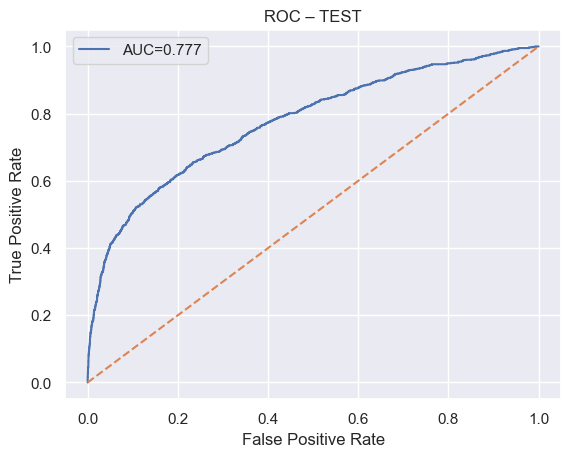

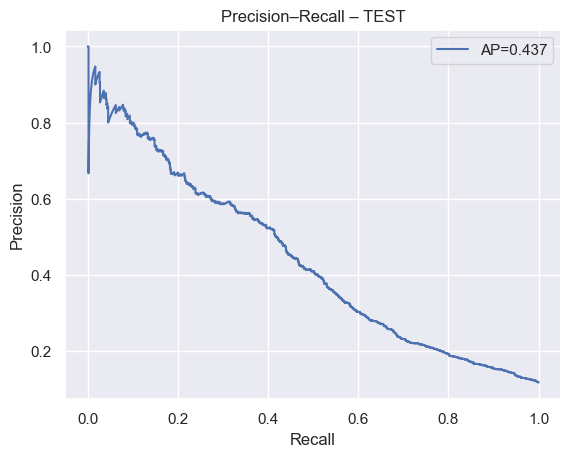

In [7]:

def evaluate_split(name, y_true, y_proba, save_dir=None, prefix="baseline"):
    y_pred = (y_proba >= 0.5).astype(int)
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)
    report = classification_report(y_true, y_pred, digits=3)
    cm = confusion_matrix(y_true, y_pred)

    print(f"\n[{name}] ROC-AUC: {roc:.4f} | PR-AUC: {pr:.4f}")
    print(f"[{name}] Classification report:\n{report}")
    print(f"[{name}] Confusion matrix:\n{cm}")

    # vẽ ROC
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={roc:.3f}")
    plt.plot([0,1],[0,1],"--")
    plt.title(f"ROC – {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if save_dir:
        plt.savefig(save_dir / f"{prefix}_{name.lower()}_roc.png", bbox_inches="tight")
    plt.show()

    # vẽ PR
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(rec, prec, label=f"AP={pr:.3f}")
    plt.title(f"Precision–Recall – {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    if save_dir:
        plt.savefig(save_dir / f"{prefix}_{name.lower()}_pr.png", bbox_inches="tight")
    plt.show()

    return {
        "split": name,
        "roc_auc": roc,
        "pr_auc": pr,
        "accuracy": (y_pred == y_true).mean()
    }, cm

# VALID
yv_proba = pipe.predict_proba(X_valid)[:, 1]
valid_metrics, cm_valid = evaluate_split("VALID", y_valid, yv_proba, save_dir=REPORTS_DIR, prefix="baseline")

# TEST
yt_proba = pipe.predict_proba(X_test)[:, 1]
test_metrics, cm_test = evaluate_split("TEST", y_test, yt_proba, save_dir=REPORTS_DIR, prefix="baseline")


In [8]:

import json
from joblib import dump

# lưu metrics tổng hợp
metrics_df = pd.DataFrame([valid_metrics, test_metrics])
display(metrics_df)

metrics_path = REPORTS_DIR / "baseline_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)
print(f"Đã lưu metrics -> {metrics_path}")

# lưu confusion matrices (JSON)
cms = {"valid": cm_valid.tolist(), "test": cm_test.tolist()}
with open(REPORTS_DIR / "baseline_confusion_matrices.json", "w") as f:
    json.dump(cms, f, indent=2)
print("Đã lưu confusion matrices JSON.")

# lưu model
model_path = MODELS_DIR / "baseline_logreg.joblib"
dump(pipe, model_path)
print(f"Đã lưu model -> {model_path}")


,split,roc_auc,pr_auc,accuracy
0,VALID,0.764353,0.40285,0.752157
1,TEST,0.776712,0.43721,0.760478


Đã lưu metrics -> C:\Users\ACER\Downloads\python\data-mining-assignment\reports\baseline_metrics.csv
Đã lưu confusion matrices JSON.
Đã lưu model -> C:\Users\ACER\Downloads\python\data-mining-assignment\models\baseline_logreg.joblib



## Next steps

1. **So sánh mô hình:**
   - Decision Tree, Random Forest / ExtraTrees
   - (Tuỳ chọn) HistGradientBoosting / XGBoost / LightGBM

2. **Xử lý imbalance:**
   - Thử **SMOTE** (chỉ áp dụng trên tập train)
   - So sánh với `class_weight="balanced"`

3. **Tối ưu threshold theo kịch bản Marketing:**
   - Ưu tiên **Recall** (không bỏ sót leads) hoặc **Precision** (giảm chi phí gọi nhầm)
   - Vẽ **Precision–Recall vs Threshold** để chọn ngưỡng

4. **Validation chuẩn hơn:**
   - Stratified K-Fold (giảm variance so với 1 split)

5. **Giải thích mô hình:**
   - Kiểm tra hệ số LR (sau OneHot) / Feature importance (RF)



### Vì sao nên import module trong `src/`?
- Notebook **gọn** vì không lặp lại code xử lý.
- Dễ **tái sử dụng** khi thử nhiều mô hình (DT/RF/XGB).
- Đảm bảo **đồng bộ** preprocess giữa notebook và script CLI (`python -m src.train_baseline`).


In [9]:

import sklearn, sys
print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)


Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
pandas: 2.3.3
numpy: 2.3.4
scikit-learn: 1.7.2
